In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.functional import sigmoid

from torchvision.datasets import ImageFolder
from torchvision import transforms

## Hyper Parametrs

In [3]:
batch_size = 32
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device=device)
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_datasets = ImageFolder('PetImages/train', transform=transform)
val_datasets = ImageFolder('PetImages/val', transform=transform)
test_datasets = ImageFolder('PetImages/test', transform=transform)

In [7]:
train_dataloader = DataLoader(
    train_datasets, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

val_dataloader = DataLoader(
    val_datasets, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

test_dataloader = DataLoader(
    test_datasets, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True,
)

In [8]:
for train_images,_ in train_dataloader:
    print(train_images.shape)
    break

torch.Size([32, 3, 227, 227])


## AlexNet Model Architecture

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(3, stride=2),
            nn.Flatten()
        )

        self.fcn = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1),
        )
    
    def forward(self, x):
        features_map = self.feature_extractor(x)
        output = self.fcn(features_map)
        return output

alexnet = AlexNet()
# alexnet(train_images).shape

In [ ]:
# !pip install torchsummary
# from torchsummary import summary
# summary(alexnet.to('cuda'), (3, 227, 227))

## Training Pipeline 

In [ ]:
n_epoch = 10
model = AlexNet().to(device=device)
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_one_step(model, criteria, optimizer, images, labels):
    model.train() ## drop out layer, batch normalization 
    optimizer.zero_grad() 

    ## Forward Pass 
    results = model(images)
    results = results.squeeze()
    labels = labels.type(torch.float)
    loss = criteria(results, labels)

    ## backward Pass
    loss.backward()
    optimizer.step()
    return loss, results

def val_one_step(model, criteria, images, labels):
    model.eval()

    with torch.no_grad():
        ## Forward Pass 
        results = model(images)
        results = results.squeeze()
        labels = labels.type(torch.float)
        loss = criteria(results, labels)
    return loss, results

# @torch.no_grad()
# def val_one_step(model, criteria, images, labels):
#     model.eval()

#     ## Forward Pass 
#     results = model(images)
#     results = results.squeeze()
#     labels = labels.type(torch.float)
#     loss = criteria(results, labels)
#     return loss, results

In [ ]:
class EarlyStopping:
    def __init__(self,patience =5, min_delta = 0.001):
        self.patience =patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def __call__(self,)

In [ ]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(1, n_epoch + 1):
    
    ## Training 
    train_epoch_loss = 0
    train_epoch_correct_prediction = 0
    for train_images, train_labels in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        loss, results = train_one_step(model, criteria, optimizer, train_images, train_labels)
        train_epoch_loss += loss.item()
        results = sigmoid(results).round()
        
        correct_prediction = (results == train_labels).type(torch.float).sum()
        train_epoch_correct_prediction += correct_prediction.item()

    train_epoch_loss /= len(train_dataloader)
    train_loss.append(train_epoch_loss)

    epoch_train_acc = train_epoch_correct_prediction / len(train_datasets)
    train_acc.append(epoch_train_acc)


    ## Validation
    val_epoch_loss = 0
    val_epoch_correct_prediction = 0
    for val_images, val_labels in tqdm(val_dataloader, desc=f'Validation'):
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        loss, results = val_one_step(model, criteria, val_images, val_labels)
        val_epoch_loss += loss.item()
        results = sigmoid(results).round()
        
        correct_prediction = (results == val_labels).type(torch.float).sum()
        val_epoch_correct_prediction += correct_prediction.item()

    val_epoch_loss /= len(val_dataloader)
    val_loss.append(val_epoch_loss)

    epoch_val_acc = val_epoch_correct_prediction / len(val_datasets)
    val_acc.append(epoch_val_acc)
    
    print(f"Epoch {epoch} of {n_epoch}: Train Acc: {epoch_train_acc}, Train Loss: {train_epoch_loss}")
    print(f"Epoch {epoch} of {n_epoch}: Val Acc: {epoch_val_acc}, Val Loss: {val_epoch_loss}")



Training 1 of 10:  94%|█████████▍| 514/547 [00:22<00:01, 22.46it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:06<00:00, 19.45it/s]


Epoch 1 of 10: Train Acc: 0.8538035091730011, Train Loss: 0.33430233654962815
Epoch 1 of 10: Val Acc: 0.8668978394238464, Val Loss: 0.3022671645601927


Training 2 of 10:  59%|█████▉    | 325/547 [00:14<00:09, 22.35it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 24.92it/s]


Epoch 2 of 10: Train Acc: 0.8828942104360747, Train Loss: 0.27302974857512513
Epoch 2 of 10: Val Acc: 0.876767137903441, Val Loss: 0.2792282898484145


Training 3 of 10:  28%|██▊       | 154/547 [00:07<00:17, 22.13it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 25.01it/s]


Epoch 3 of 10: Train Acc: 0.9060410356061039, Train Loss: 0.22529373615571524
Epoch 3 of 10: Val Acc: 0.8735662843424913, Val Loss: 0.29401882737874985


Training 4 of 10:  48%|████▊     | 265/547 [00:12<00:12, 22.04it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 24.06it/s]


Epoch 4 of 10: Train Acc: 0.922786763445162, Train Loss: 0.188588583099586
Epoch 4 of 10: Val Acc: 0.8919711923179514, Val Loss: 0.27545130975797016


Training 5 of 10:  59%|█████▉    | 325/547 [00:15<00:10, 21.95it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:05<00:00, 23.21it/s]


Epoch 5 of 10: Train Acc: 0.9397039492484426, Train Loss: 0.147921145473091
Epoch 5 of 10: Val Acc: 0.8463590290744198, Val Loss: 0.3549892264181527


Training 6 of 10:  15%|█▌        | 84/547 [00:04<00:20, 22.27it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:05<00:00, 22.63it/s]


Epoch 6 of 10: Train Acc: 0.9573641195633538, Train Loss: 0.1088083757792465
Epoch 6 of 10: Val Acc: 0.8946385702854095, Val Loss: 0.31517666426755614


Training 7 of 10:   1%|          | 4/547 [00:00<00:57,  9.42it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 23.95it/s]


Epoch 7 of 10: Train Acc: 0.9667943075955878, Train Loss: 0.08428430040383973
Epoch 7 of 10: Val Acc: 0.8941050946919178, Val Loss: 0.3350560876493484


Training 8 of 10:  15%|█▌        | 83/547 [00:04<00:20, 22.49it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 23.87it/s]


Epoch 8 of 10: Train Acc: 0.9735954735097445, Train Loss: 0.0707140585322059
Epoch 8 of 10: Val Acc: 0.8962389970658843, Val Loss: 0.33223475435338284


Training 9 of 10:  38%|███▊      | 208/547 [00:09<00:15, 22.24it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 24.94it/s]


Epoch 9 of 10: Train Acc: 0.9781105332342688, Train Loss: 0.058017687696258674
Epoch 9 of 10: Val Acc: 0.8895705521472392, Val Loss: 0.41522360203187847


Training 10 of 10:  18%|█▊        | 97/547 [00:04<00:20, 22.25it/s]/home/fm-pc-lt-278/miniconda3/envs/torch/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 118/118 [00:04<00:00, 25.38it/s]

Epoch 10 of 10: Train Acc: 0.9841687146367949, Train Loss: 0.04512941533024125
Epoch 10 of 10: Val Acc: 0.8967724726593759, Val Loss: 0.3449826912354615


## Training Curve

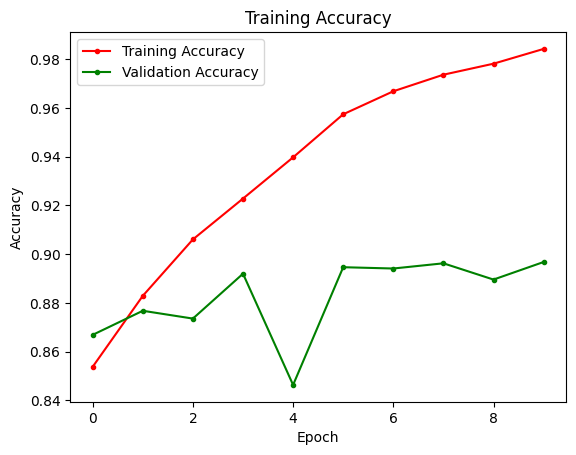

In [ ]:
plt.figure()
plt.plot(train_acc, 'r.-')
plt.plot(val_acc, 'g.-')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title("Training Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

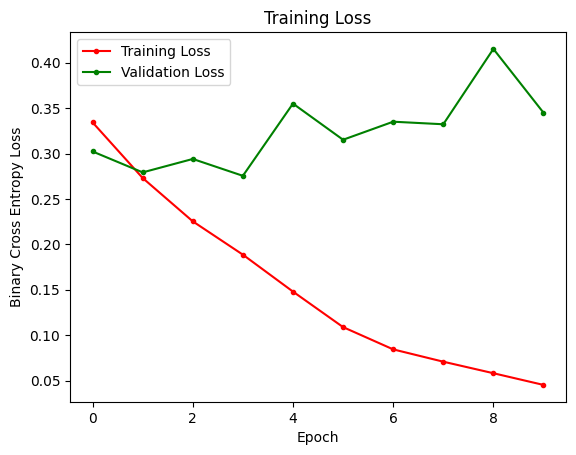

In [ ]:
plt.figure()
plt.plot(train_loss, 'r.-')
plt.plot(val_loss, 'g.-')
plt.xlabel("Epoch")
plt.ylabel('Binary Cross Entropy Loss')
plt.title("Training Loss")
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## Evaluation 

In [69]:
@torch.no_grad()
def evaluate(model, test_dataloader):
    model.eval()

    ## Forward Pass 
    total_correct_prediction = 0
    for test_images, test_labels in tqdm(test_dataloader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        results = model(test_images)
        results = results.squeeze()
        results = sigmoid(results).round()
        correct_prediction = (results == test_labels).type(torch.float).sum()
        total_correct_prediction += correct_prediction.item()

    acc = total_correct_prediction / len(test_dataloader)
    return acc

print("Accuracy of model in test datasets: ", evaluate(model, test_dataloader))

100%|██████████| 118/118 [00:04<00:00, 26.01it/s]

Accuracy of model in test datasets:  28.440677966101696


## Model Saving 

In [71]:
torch.save(model, 'model_with_arch.pt')

In [72]:
loaded_model = torch.load('model_with_arch.pt')

In [73]:
evaluate(loaded_model, test_dataloader)

100%|██████████| 118/118 [00:04<00:00, 25.49it/s]


28.440677966101696

In [75]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'model_weights.pt')

In [94]:
new_model = AlexNet().to(device=device)

In [95]:
evaluate(new_model, test_dataloader)

100%|██████████| 118/118 [00:04<00:00, 25.14it/s]


15.898305084745763

In [96]:
alex_weights = torch.load('model_weights.pt')

In [97]:
new_model.load_state_dict(alex_weights)

<All keys matched successfully>

In [98]:
evaluate(new_model, test_dataloader)

  0%|          | 0/118 [00:00<?, ?it/s]

100%|██████████| 118/118 [00:04<00:00, 25.21it/s]


28.440677966101696